## **Identitas Tim & Hasil Proyek**

**Informasi Umum**
* **Nama Proyek:** [A25-CS019] RECALL (Recommendation & Churn Analysis Learning Lab)
* **Tema Proyek:** [AC-01] Telco - Product Recommendation Offer based on Customer Behaviour
* **Advisor:** Eko Pebrisulistiyo

**Anggota Tim**

| No | Nama Anggota | ID Bangkit | Role | Institusi |
| :--- | :--- | :--- | :--- | :--- |
| 1 | **Alamahul Bayan** | F367D5Y0138 | Front-End Web & Back-End with AI | Institut Teknologi Garut |
| 2 | **Bubu Bukhori Muslim** | M535D5Y0368 | Machine Learning | Institut Teknologi Garut |
| 3 | **Muhammad Fahmi Faisal** | SF367D5Y1242 | Front-End Web & Back-End with AI | Institut Teknologi Garut |
| 4 | **Vito Gunawan** | M367D5Y1944 | Machine Learning | Institut Teknologi Garut |
| 5 | **Vannesa Ayuni Riskita** | F308D5X1933 | Front-End Web & Back-End with AI | Universitas Riau |

**Hasil Model**

* Algoritma: Random Forest
* Akurasi: 94%

# Import Library

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import joblib

from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Ringkasan Dataset

Tabel di atas menampilkan sampel **10 baris pertama** dari dataset berisi **10.000 entri** dan **12 kolom**. Dataset mencakup informasi perilaku pelanggan, seperti:

- **customer_id** – ID unik pelanggan  
- **plan_type** – Jenis paket (Prepaid/Postpaid)  
- **device_brand** – Merek perangkat yang digunakan  
- **avg_data_usage_gb** – Rata-rata penggunaan data per bulan  
- **pct_video_usage** – Persentase penggunaan untuk streaming video  
- **avg_call_duration** – Durasi panggilan rata-rata  
- **sms_freq** – Frekuensi SMS  
- **monthly_spend** – Pengeluaran bulanan  
- **topup_freq** – Frekuensi isi ulang (untuk prepaid)  
- **travel_score** – Indikator intensitas perjalanan  
- **complaint_count** – Jumlah keluhan tercatat  
- **target_offer** – Kategori penawaran yang relevan (label untuk klasifikasi)

Dataset ini digunakan untuk menganalisis perilaku pelanggan dan memprediksi jenis penawaran yang paling sesuai.


In [ ]:
import pandas as pd
print("--- 1. Loading Dataset ---")
try:
    df = pd.read_csv('/content/drive/MyDrive/Asah/Capstone/Dataset/ac-01_telco_customer_behavior_mock_data.csv')
    print(f"Dataset berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom.")
except FileNotFoundError:
    print("Error: File csv tidak ditemukan.")
    exit()
df.head(10)

--- 1. Loading Dataset ---
Dataset berhasil dimuat: 10000 baris, 12 kolom.


,customer_id,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,monthly_spend,topup_freq,travel_score,complaint_count,target_offer
0,C00001,Prepaid,Realme,1.50,0.804146,7.98,13,70000,4,0.284419,0,General Offer
1,C00002,Postpaid,Vivo,1.09,0.107686,9.56,9,63000,3,0.115086,0,General Offer
2,C00003,Postpaid,Xiaomi,3.24,0.313894,4.61,13,89000,7,0.402998,0,General Offer
3,C00004,Prepaid,Apple,5.32,0.420158,6.96,8,67000,4,0.302169,0,General Offer
4,C00005,Prepaid,Huawei,1.91,0.251638,11.01,21,72000,5,0.487911,0,General Offer
5,C00006,Prepaid,Oppo,3.30,0.478873,6.53,17,54000,3,0.372135,0,Top-up Promo
6,C00007,Prepaid,Oppo,9.87,0.375882,11.17,11,140000,5,0.308220,1,Device Upgrade Offer
7,C00008,Postpaid,Oppo,13.91,0.465977,7.72,14,180000,4,0.288257,2,Device Upgrade Offer
8,C00009,Postpaid,Realme,1.25,0.222178,10.73,20,72000,2,0.270601,0,General Offer
9,C00010,Postpaid,Huawei,3.66,0.196774,13.36,11,83000,1,0.342730,0,General Offer


#Handling Missing Value

In [ ]:
# Cek jumlah null
null_counts = df.isnull().sum()

if null_counts[null_counts > 0].empty:
    print("Tidak ada data kosong yang ditemukan.")
else:
    print(f"Data kosong sebelum handling:\n{null_counts[null_counts > 0]}")

# Pisahkan kolom numerik dan kategorikal
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Strategi 1: Isi Null Numerik dengan MEDIAN (tahan terhadap outlier)
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"  - Mengisi null pada '{col}' dengan median: {median_val}")

# Strategi 2: Isi Null Kategorikal dengan MODE (nilai yang sering muncul)
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"  - Mengisi null pada '{col}' dengan mode: {mode_val}")

print("Handling missing values selesai.")



Tidak ada data kosong yang ditemukan.
Handling missing values selesai.


## Handling Negative Values

In [ ]:
# 1. Pilih semua kolom yang bertipe angka (float atau int)
numeric_cols = df.select_dtypes(include=['number']).columns

print("Memeriksa nilai negatif di seluruh kolom numerik...")

# 2. Loop otomatis untuk mengecek dan menghitung nilai negatif (Hanya untuk laporan/log)
for col in numeric_cols:
    neg_count = (df[col] < 0).sum()
    if neg_count > 0:
        print(f" -> Ditemukan {neg_count} nilai negatif pada kolom '{col}'")

# 3. Eksekusi: Ubah semua nilai negatif menjadi 0 sekaligus
df[numeric_cols] = df[numeric_cols].clip(lower=0)

print("\nSelesai! Semua nilai negatif pada kolom numerik telah diubah menjadi 0.")

# 4. Verifikasi Akhir (Opsional)
print("Cek nilai minimum baru:")
print(df[numeric_cols].min())

Memeriksa nilai negatif di seluruh kolom numerik...
 -> Ditemukan 229 nilai negatif pada kolom 'avg_call_duration'
 -> Ditemukan 2 nilai negatif pada kolom 'monthly_spend'

Selesai! Semua nilai negatif pada kolom numerik telah diubah menjadi 0.
Cek nilai minimum baru:
avg_data_usage_gb    0.030000
pct_video_usage      0.000000
avg_call_duration    0.000000
sms_freq             4.000000
monthly_spend        0.000000
topup_freq           0.000000
travel_score         0.003376
complaint_count      0.000000
dtype: float64


#SYNTHETIC LABEL GENERATION (SCORING BASED)

### Generating Specific Product Labels (Scoring Method — 16 Classes)

Proses ini membangun label produk spesifik berdasarkan **scoring perilaku pelanggan** dan **kategori pengeluaran**. Tahapan yang dilakukan meliputi:

1. **Segmentasi Pengeluaran (Spend Level)**  
   Pelanggan dikelompokkan menjadi tiga kategori (`Low`, `Mid`, `High`) menggunakan metode *quantile cut* pada variabel `monthly_spend`.

2. **Normalisasi Perilaku Utama**
   Enam perilaku pelanggan dinormalisasi menggunakan persentil ranking:
   - Penggunaan data (`rank_data`)
   - Konsumsi video (`rank_video`)
   - Durasi panggilan (`rank_call`)
   - Frekuensi SMS (`rank_sms`)
   - Skor perjalanan (`rank_travel`)
   - Frekuensi top-up (`rank_topup`)

3. **Prioritas Produk (Level 1 Rule)**
   - Keluhan ⇒ **Retention Offer**
   - High spend + Apple/Samsung ⇒ **Device Upgrade Offer**
   - Postpaid + High spend ⇒ **Family Plan**

4. **Behavior Scoring (Level 2)**
   Menentukan perilaku dominan berdasarkan skor tertinggi dari enam parameter perilaku.

5. **Mapping ke 16 Produk Akhir (Level 3)**
   Label produk ditentukan berdasarkan:
   - Perilaku dominan
   - Tingkat pengeluaran
   - Ambang skor tertentu

6. **Pembersihan Kolom**
   Kolom intermediate seperti `spend_level` dan `rank_*` dihapus agar dataset tetap bersih.

### Distribusi Target Offer (Setelah Balancing — 16 Kelas)

Berikut distribusi akhir untuk masing-masing kelas produk:

- **Retention Offer** — 3868  
- **SMS Bundle** — 882  
- **Streaming Partner Pack** — 843  
- **Top-up Promo** — 830  
- **Data Booster Premium** — 552  
- **Family Plan** — 543  
- **Voice Bundle Basic** — 441  
- **Roaming Pass Basic** — 387  
- **Voice Bundle Standard** — 377  
- **Roaming Pass Standard** — 359  
- **Device Upgrade Offer** — 238  
- **Data Booster Standard** — 232  
- **Voice Bundle Premium** — 185  
- **General Offer** — 120  
- **Roaming Pass Premium** — 117  
- **Data Booster Basic** — 26  

Distribusi ini menunjukkan bahwa model menghasilkan segmentasi multi-produk yang variatif, sesuai dengan 16 kategori penawaran yang telah didefinisikan.


In [ ]:
print("\n--- 2.1 Generating Specific Product Labels (Scoring Method - 16 Classes)")

df['spend_level'] = pd.qcut(df['monthly_spend'], q=3, labels=['Low', 'Mid', 'High'])

# 2. Normalisasi Fitur Utama (agar bisa dibandingkan mana yang dominan)
df['rank_data'] = df['avg_data_usage_gb'].rank(pct=True)
df['rank_video'] = df['pct_video_usage'].rank(pct=True)
df['rank_call'] = df['avg_call_duration'].rank(pct=True)
df['rank_sms'] = df['sms_freq'].rank(pct=True)
df['rank_travel'] = df['travel_score'].rank(pct=True)
df['rank_topup'] = df['topup_freq'].rank(pct=True)

def assign_balanced_product(row):

    #  LEVEL 1: PRIORITY / NICHE (Kondisi Khusus)
    # Retention tetap prioritas utama jika ada komplain
    if row['complaint_count'] >= 1:
        return 'Retention Offer'

    # Device Upgrade: Hanya untuk High Spend yang pakai brand tertentu
    # Kita batasi rank data < 0.8 agar tidak merebut semua jatah Data Premium
    if row['spend_level'] == 'High' and row['device_brand'] in ['Apple', 'Samsung'] and row['rank_data'] < 0.8:
        return 'Device Upgrade Offer'

    # Family Plan: Postpaid High Spend yang tidak kena filter di atas
    if row['spend_level'] == 'High' and row['plan_type'] == 'Postpaid' and row['rank_call'] < 0.8:
        return 'Family Plan'

    # --- LEVEL 2: BEHAVIOR SCORING ---
    # Kita cari perilaku mana yang skor rank-nya PALING TINGGI

    behaviors = {
        'travel': row['rank_travel'],
        'video': row['rank_video'],
        'sms': row['rank_sms'],
        'topup': row['rank_topup'],
        'call': row['rank_call'],
        'data': row['rank_data']
    }

    # Ambil perilaku dengan skor tertinggi (Dominant)
    dominant_behavior = max(behaviors, key=behaviors.get)
    score = behaviors[dominant_behavior]

    # LEVEL 3: MAPPING KE PRODUK (16 ITEMS)

    # A. TRAVELER DOMINANT
    if dominant_behavior == 'travel' and score > 0.6:
        if row['spend_level'] == 'High': return 'Roaming Pass Premium'
        if row['spend_level'] == 'Mid': return 'Roaming Pass Standard'
        return 'Roaming Pass Basic' # Low Spend

    # B. VIDEO DOMINANT Streaming Partner Pack
    if dominant_behavior == 'video' and score > 0.6:
        return 'Streaming Partner Pack'

    # C. SMS DOMINANT
    if dominant_behavior == 'sms' and score > 0.7:
        return 'SMS Bundle'

    # D. TOPUP DOMINANT
    if dominant_behavior == 'topup' and score > 0.7:
        return 'Top-up Promo'

    # E. CALL DOMINANT (Voice Bundle)
    if dominant_behavior == 'call':
        if row['spend_level'] == 'High': return 'Voice Bundle Premium'
        if row['spend_level'] == 'Mid': return 'Voice Bundle Standard'
        return 'Voice Bundle Basic' # Low Spend

    # F. DATA DOMINANT & GENERAL OFFER (Catch All)

    if row['spend_level'] == 'High': return 'Data Booster Premium'
    if row['spend_level'] == 'Mid': return 'Data Booster Standard'

    if row['rank_data'] > 0.4:
        return 'Data Booster Basic'

    return 'General Offer'

# Terapkan Fungsi
df['target_offer'] = df.apply(assign_balanced_product, axis=1)

# Hapus kolom bantuan agar bersih
df.drop(['spend_level', 'rank_data', 'rank_video', 'rank_call', 'rank_sms', 'rank_travel', 'rank_topup'], axis=1, inplace=True)

# --- Validasi Hasil ---
print("\nDistribusi Target Offer (Final Balanced - 16 Kelas):")
print(df['target_offer'].value_counts())



--- 2.1 Generating Specific Product Labels (Scoring Method - 16 Classes)

Distribusi Target Offer (Final Balanced - 16 Kelas):
target_offer
Retention Offer           3868
SMS Bundle                 882
Streaming Partner Pack     843
Top-up Promo               830
Data Booster Premium       552
Family Plan                543
Voice Bundle Basic         441
Roaming Pass Basic         387
Voice Bundle Standard      377
Roaming Pass Standard      359
Device Upgrade Offer       238
Data Booster Standard      232
Voice Bundle Premium       185
General Offer              120
Roaming Pass Premium       117
Data Booster Basic          26
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)


## **Penjelasan Output EDA**
## 1. Statistik Deskriptif

Statistik deskriptif menunjukkan ringkasan nilai untuk fitur numerik pada dataset pelanggan. Beberapa temuan penting:

- **avg_data_usage_gb** memiliki rata-rata sekitar **5.96 GB**, dengan nilai maksimum yang cukup tinggi (**39 GB**) sehingga terdapat variasi besar antar pelanggan.
- **pct_video_usage** memiliki mean sekitar **0.40**, mengindikasikan bahwa sekitar 40% aktivitas data rata-rata digunakan untuk menonton video.
- **avg_call_duration** rata-rata berada pada **10.01 menit**, menunjukkan penggunaan panggilan yang relatif moderat.
- **sms_freq** rata-rata **15 SMS**, dengan maksimum **31**, menandakan penggunaan SMS masih relevan namun tidak dominan.
- **monthly_spend** memiliki standar deviasi yang sangat besar (**±46.000**), menunjukkan perbedaan signifikan antara pelanggan low spend dan high spend.
- **complaint_count** memiliki nilai rata-rata **0.49**, yang berarti sebagian pelanggan memiliki riwayat komplain.

Secara umum, statistik deskriptif memperlihatkan distribusi yang bervariasi dan adanya perbedaan signifikan antar segmen pengguna.

---

## 2. Distribusi Target Penawaran (Imbalance Check)

Distribusi kelas target sangat tidak seimbang (imbalance). Temuan utama:

- **Retention Offer** mendominasi dengan lebih dari **3.800 pelanggan**, jauh lebih tinggi dibanding kategori lain.
- Kategori besar lainnya adalah **SMS Bundle**, **Streaming Partner Pack**, dan **Top-up Promo** dengan jumlah antara 800–900.
- Kelas terkecil adalah **Data Booster Basic**, hanya **26 entri**, sehingga berpotensi menyebabkan masalah dalam pelatihan model jika tidak ditangani.
- Ketidakseimbangan ini penting untuk diperhatikan pada tahap *modeling* karena dapat berdampak pada akurasi prediksi.

---

## 3. Average Monthly Spend per Target Offer

Analisis rata-rata pengeluaran bulanan menunjukkan pola menarik mengenai daya beli pelanggan per jenis penawaran:

- **Data Booster Premium** memiliki rata-rata pengeluaran tertinggi (**182.768**), menandakan kelompok ini adalah pelanggan dengan intensitas penggunaan data tinggi dan daya beli besar.
- **Family Plan** (**165.494**) dan **Voice Bundle Premium** (**155.249**) juga termasuk kelompok high spender.
- **Roaming Pass Premium** dan **Device Upgrade Offer** menempati posisi menengah ke atas.
- Kategori dengan pengeluaran terendah adalah:
  - **Voice Bundle Basic**
  - **Roaming Pass Basic**
  - **General Offer**
---

## 4. Identifikasi Tipe Kolom dalam Dataset

## **Kolom Numerik**

Kolom-kolom berikut berisi nilai angka dan biasanya digunakan untuk perhitungan statistik, model prediktif, atau normalisasi:

* **avg_data_usage_gb** – rata-rata penggunaan data (GB)
* **pct_video_usage** – persentase penggunaan untuk video
* **avg_call_duration** – rata-rata durasi panggilan
* **sms_freq** – frekuensi SMS
* **monthly_spend** – pengeluaran bulanan
* **topup_freq** – frekuensi top-up
* **travel_score** – skor mobilitas/perjalanan
* **complaint_count** – jumlah komplain

###  **Kolom Kategorikal**

Kolom berikut berisi label/kelas dan biasanya di-*encode* sebelum masuk ke model machine learning:

* **customer_id** – ID unik pelanggan
* **plan_type** – jenis paket (Prepaid/Postpaid)
* **device_brand** – merek perangkat pelanggan
* **target_offer** – jenis penawaran yang diberikan (label target)

---

### 5. Hubungan antara *plan_type* dan *Target Offer*

* **Retention Offer** menjadi penawaran yang **paling banyak diberikan**, baik untuk pelanggan **Prepaid** maupun **Postpaid**.
* **Prepaid** mendominasi jumlah pelanggan hampir di semua kategori offer, terutama:

  * *Roaming Pass Basic*
  * *Retention Offer*
  * *General Offer*
* **Postpaid** terlihat hanya signifikan pada beberapa offer tertentu, tetapi totalnya jauh lebih kecil dibanding Prepaid.

**Insight:**
Pelanggan Prepaid lebih sering menerima berbagai jenis target offer, dan Retention Offer menjadi penawaran yang paling masif digunakan.

---

### 6. Hubungan antara *device_brand* dan *Target Offer*

* Hampir di semua brand (Samsung, Oppo, Vivo, Xiaomi, Apple), **Retention Offer** juga muncul sebagai kategori dengan jumlah terbesar.
* Brand seperti **Samsung, Oppo, dan Vivo** mendominasi jumlah pengguna di hampir semua jenis offer.
* Brand premium seperti **Apple** memiliki jumlah yang lebih sedikit, tapi pola distribusinya tetap mengikuti—terutama banyak pada *Retention Offer* dan *Roaming Pass Basic*.

**Insight:**
Terlepas dari merek device, Retention Offer tetap paling sering diberikan. Jumlah pengguna terbanyak berasal dari brand menengah seperti Samsung, Oppo, dan Vivo.

Berikut **penjelasan singkat EDA dalam format Markdown** yang siap langsung kamu sisipkan ke **Google Colab Notebook**. Bahasanya ringkas, formal, dan fokus pada insight (bukan kode).

---

## 7. Rata-rata Complaint Count per Target Offer

Analisis ini menunjukkan rata-rata jumlah keluhan pelanggan untuk setiap jenis *target offer*.
Hasil visualisasi memperlihatkan bahwa **Retention Offer** memiliki rata-rata keluhan paling tinggi dibandingkan offer lainnya. Sementara itu, sebagian besar offer lain memiliki nilai keluhan mendekati nol.

**Insight utama:**

* Retention Offer cenderung diberikan kepada pelanggan bermasalah atau berisiko churn.
* Offer lain relatif stabil dan tidak memicu banyak keluhan.

---

## 8. Rata-rata Data Usage dan Video Usage per Target Offer

Visualisasi ini membandingkan rata-rata penggunaan data (GB) dan proporsi penggunaan video untuk setiap target offer.
Offer seperti **Data Booster Premium**, **Family Plan**, dan **Roaming Pass Premium** menunjukkan penggunaan data yang lebih tinggi.

**Insight utama:**

* Pelanggan dengan paket premium cenderung memiliki konsumsi data dan video yang lebih besar.
* Offer dengan penggunaan data rendah biasanya bersifat dasar atau promo jangka pendek.

---

## 9. Rata-rata Monthly Spend per Device Brand

Analisis ini menampilkan rata-rata pengeluaran bulanan pelanggan berdasarkan merek perangkat yang digunakan.
Terlihat bahwa pengguna **Huawei, Xiaomi, dan Apple** memiliki rata-rata pengeluaran bulanan yang relatif lebih tinggi dibandingkan merek lainnya.

**Insight utama:**

* Merek perangkat dapat menjadi indikator daya beli pelanggan.
* Perbedaan rata-rata spend antar brand tidak terlalu ekstrem, menunjukkan distribusi yang cukup merata.

---

## 10. Segmentasi Pelanggan berdasarkan Monthly Spending

Pelanggan dikelompokkan ke dalam tiga segmen pengeluaran: **Low**, **Mid**, dan **High**.
Distribusi pelanggan di ketiga segmen terlihat relatif seimbang, dengan segmen **Mid** sebagai yang paling dominan.

**Insight utama:**

* Mayoritas pelanggan berada pada segmen menengah.
* Segmentasi ini penting untuk menentukan strategi penawaran yang lebih tepat sasaran.

---

## 11. Distribusi Target Offer berdasarkan Spending Segment

Analisis ini menunjukkan penyebaran jenis offer yang diterima pelanggan pada setiap segmen pengeluaran.
**Retention Offer** mendominasi di seluruh segmen, terutama pada segmen Mid dan High.

**Insight utama:**

* Strategi retensi diterapkan secara luas tanpa hanya fokus pada pelanggan berpengeluaran rendah.
* Offer premium lebih sering muncul pada segmen High, sedangkan promo umum tersebar di semua segmen.



[Statistik Deskriptif]
                     count           mean           std       min  \
avg_data_usage_gb  10000.0       5.958883      4.192909  0.030000   
pct_video_usage    10000.0       0.402639      0.195741  0.000000   
avg_call_duration  10000.0      10.013117      4.854846  0.000000   
sms_freq           10000.0      15.010800      3.872775  4.000000   
monthly_spend      10000.0  109778.400000  46232.588492  0.000000   
topup_freq         10000.0       2.986600      1.709828  0.000000   
travel_score       10000.0       0.282441      0.158366  0.003376   
complaint_count    10000.0       0.492600      0.704127  0.000000   

                            25%            50%            75%            max  
avg_data_usage_gb      2.870000       4.990000       8.040000      39.020000  
pct_video_usage        0.265290       0.400116       0.535161       1.000000  
avg_call_duration      6.650000      10.020000      13.320000      27.770000  
sms_freq              12.000000      1

/tmp/ipython-input-2014800683.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='target_offer', data=df, order=df['target_offer'].value_counts().index, palette='viridis')


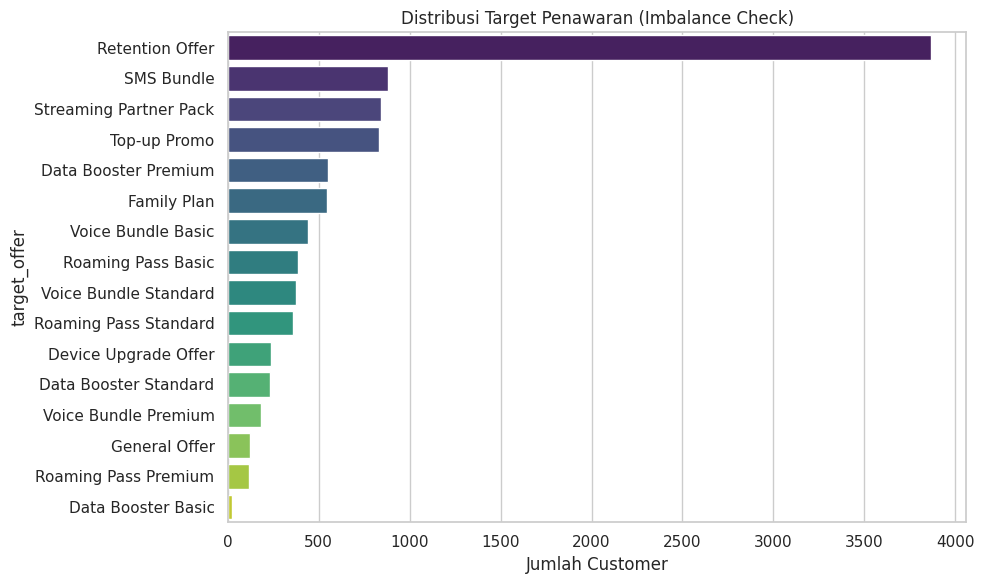

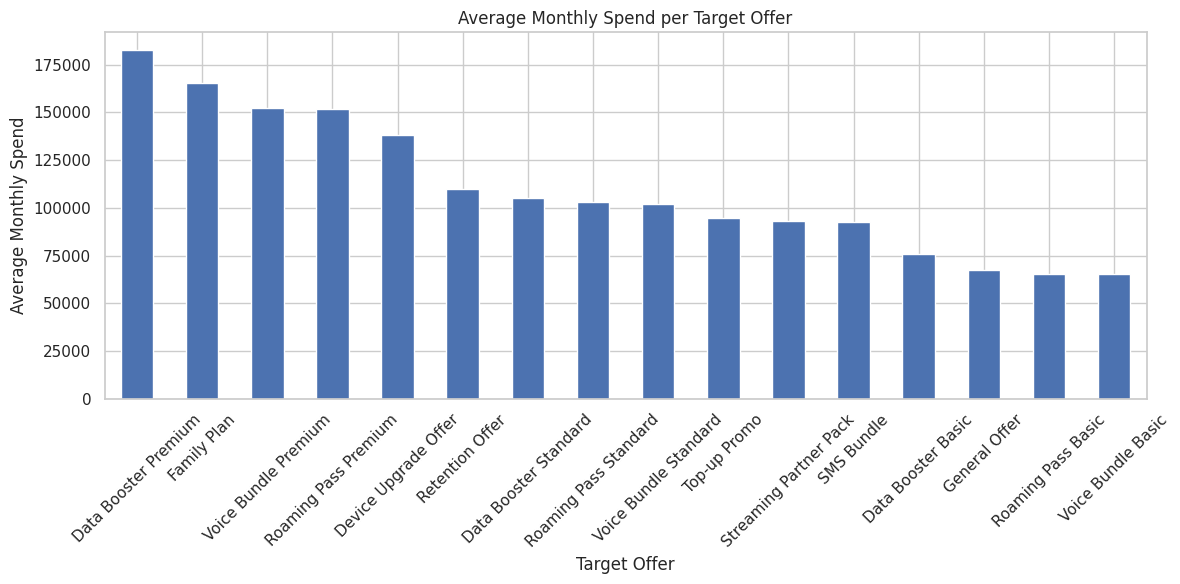


Rata-rata Monthly Spend per Offer:
target_offer
Data Booster Premium      182768.115942
Family Plan               165449.355433
Voice Bundle Premium      152540.540541
Roaming Pass Premium      151666.666667
Device Upgrade Offer      137970.588235
Retention Offer           109939.245088
Data Booster Standard     105237.068966
Roaming Pass Standard     102922.005571
Voice Bundle Standard     102222.811671
Top-up Promo               94625.301205
Streaming Partner Pack     93332.147094
SMS Bundle                 92641.723356
Data Booster Basic         75769.230769
General Offer              67225.000000
Roaming Pass Basic         65591.731266
Voice Bundle Basic         65213.151927
Name: monthly_spend, dtype: float64

[Identifikasi Tipe Kolom]
Kolom Numerik: ['avg_data_usage_gb', 'pct_video_usage', 'avg_call_duration', 'sms_freq', 'monthly_spend', 'topup_freq', 'travel_score', 'complaint_count']
Kolom Kategorikal: ['customer_id', 'plan_type', 'device_brand', 'target_offer']


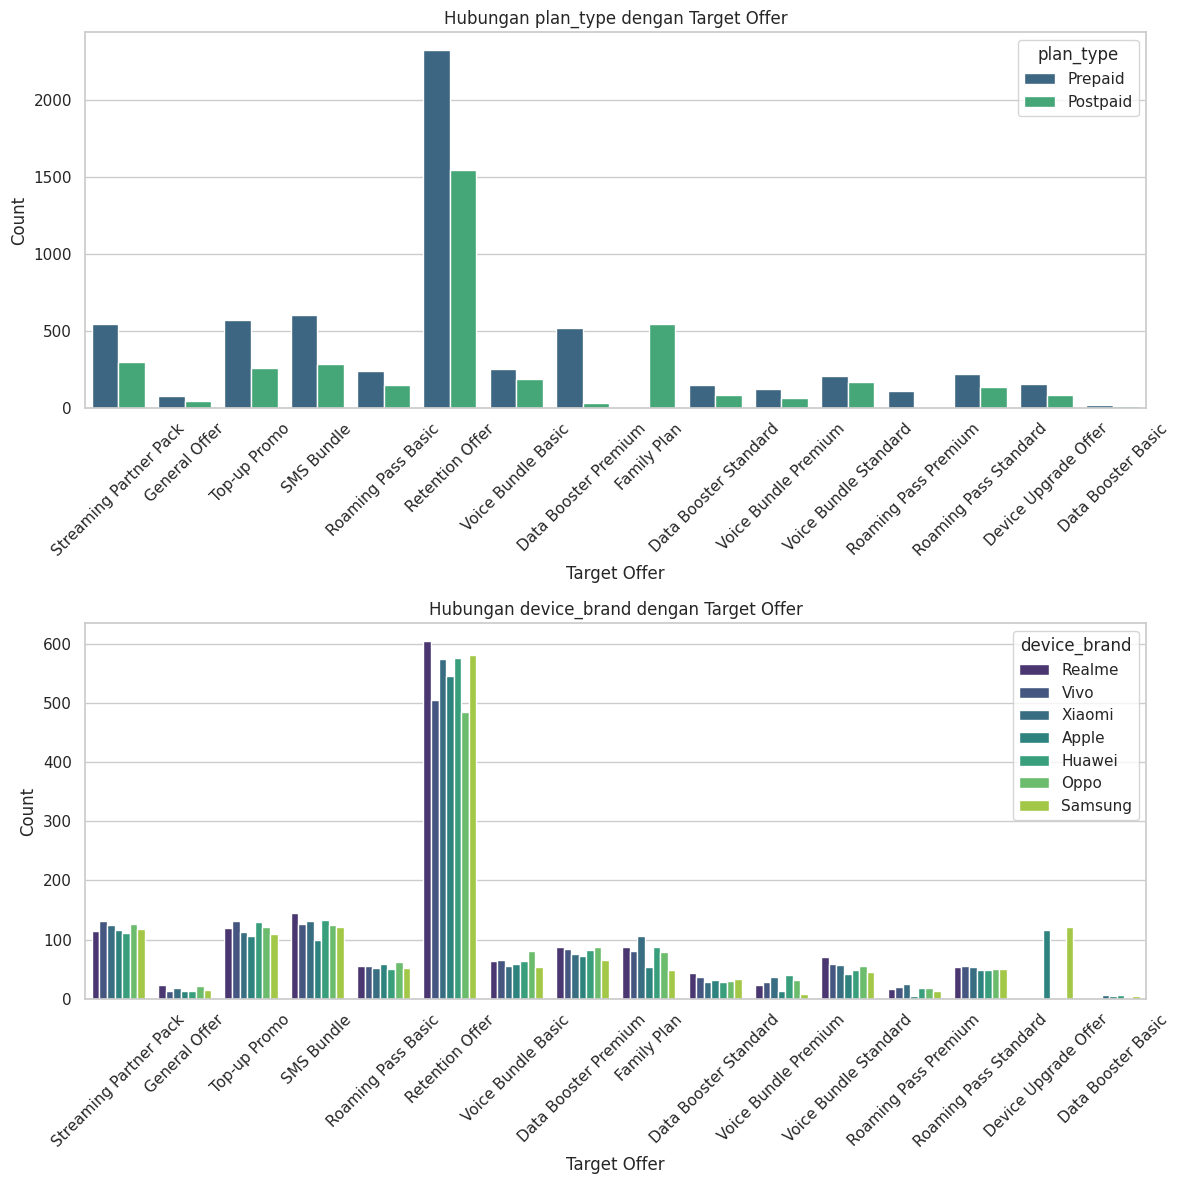

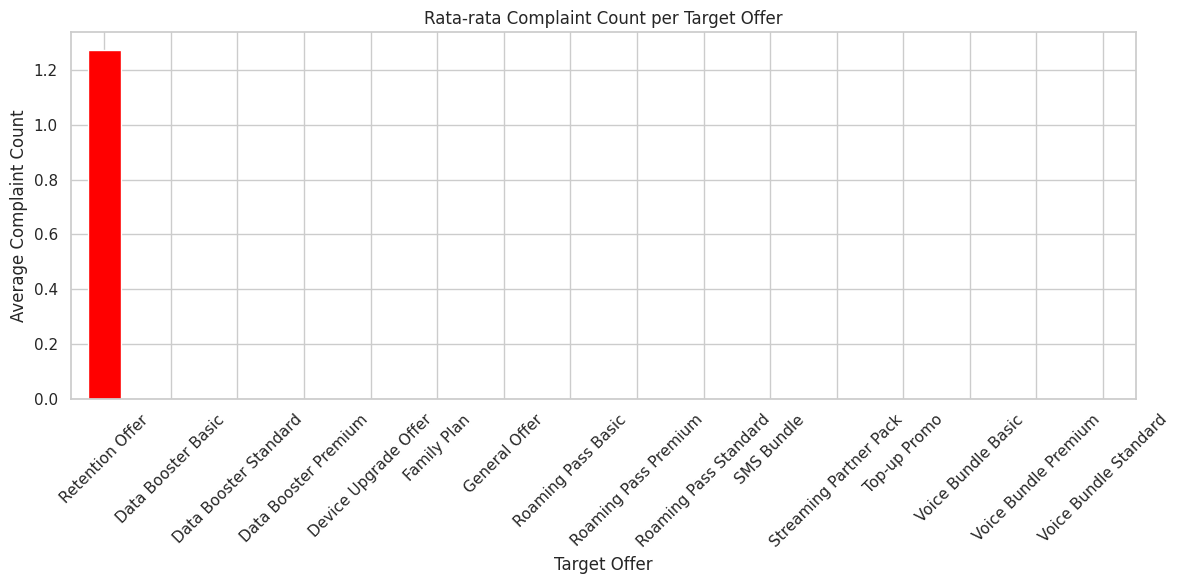


Rata-rata Complaint Count per Offer:
target_offer
Retention Offer           1.273526
Data Booster Basic        0.000000
Data Booster Standard     0.000000
Data Booster Premium      0.000000
Device Upgrade Offer      0.000000
Family Plan               0.000000
General Offer             0.000000
Roaming Pass Basic        0.000000
Roaming Pass Premium      0.000000
Roaming Pass Standard     0.000000
SMS Bundle                0.000000
Streaming Partner Pack    0.000000
Top-up Promo              0.000000
Voice Bundle Basic        0.000000
Voice Bundle Premium      0.000000
Voice Bundle Standard     0.000000
Name: complaint_count, dtype: float64


<Figure size 1400x600 with 0 Axes>

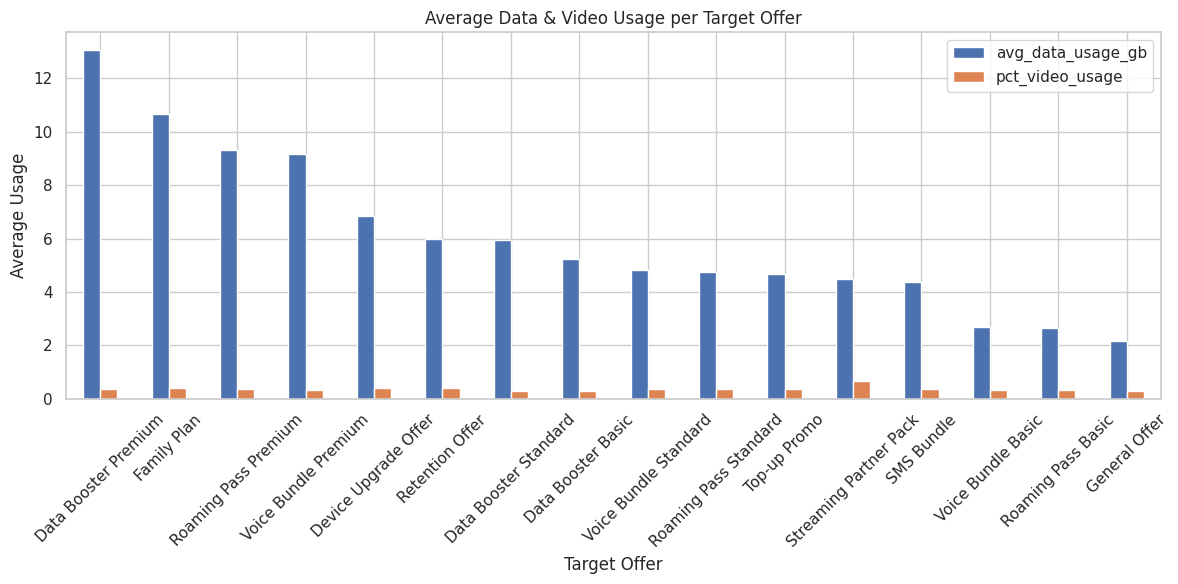


Rata-rata Usage per Offer:
                        avg_data_usage_gb  pct_video_usage
target_offer                                              
Data Booster Basic               5.253462         0.301075
Data Booster Premium            13.068043         0.360485
Data Booster Standard            5.945733         0.299690
Device Upgrade Offer             6.844664         0.412606
Family Plan                     10.660350         0.417987
General Offer                    2.167417         0.276815
Retention Offer                  5.985838         0.402666
Roaming Pass Basic               2.665426         0.346150
Roaming Pass Premium             9.317778         0.378410
Roaming Pass Standard            4.740752         0.358873
SMS Bundle                       4.383243         0.365030
Streaming Partner Pack           4.470285         0.666028
Top-up Promo                     4.669313         0.358235
Voice Bundle Basic               2.691315         0.339759
Voice Bundle Premium        

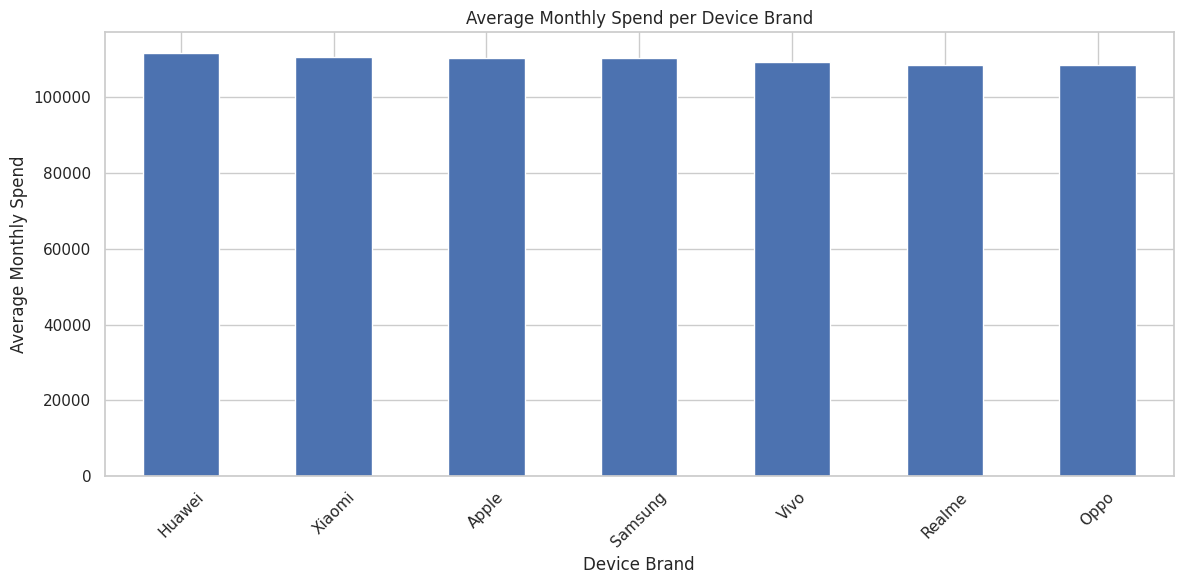


Rata-rata Monthly Spend per Device Brand:
device_brand
Huawei     111380.389430
Xiaomi     110520.576132
Apple      110272.005772
Samsung    110211.952745
Vivo       109260.215054
Realme     108453.943009
Oppo       108344.000000
Name: monthly_spend, dtype: float64


/tmp/ipython-input-2014800683.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='spend_segment', data=df, palette='viridis')


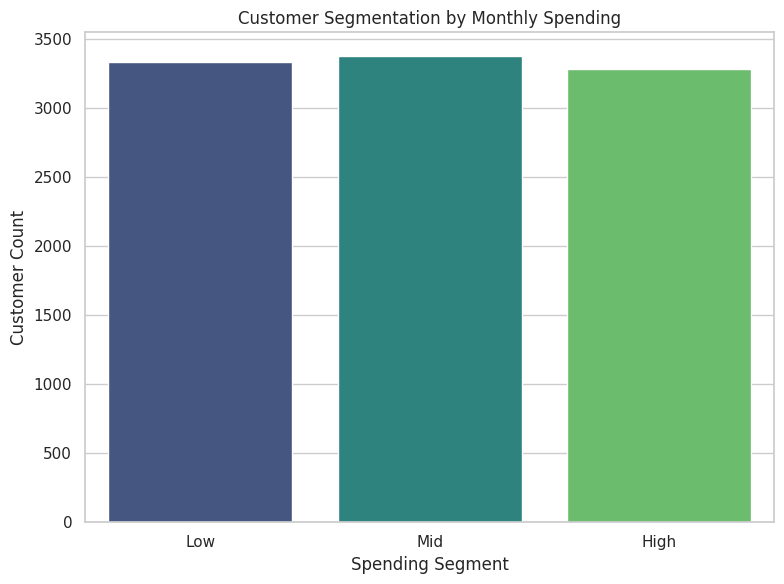


Jumlah Customer per Segment:
spend_segment
Mid     3379
Low     3335
High    3286
Name: count, dtype: int64


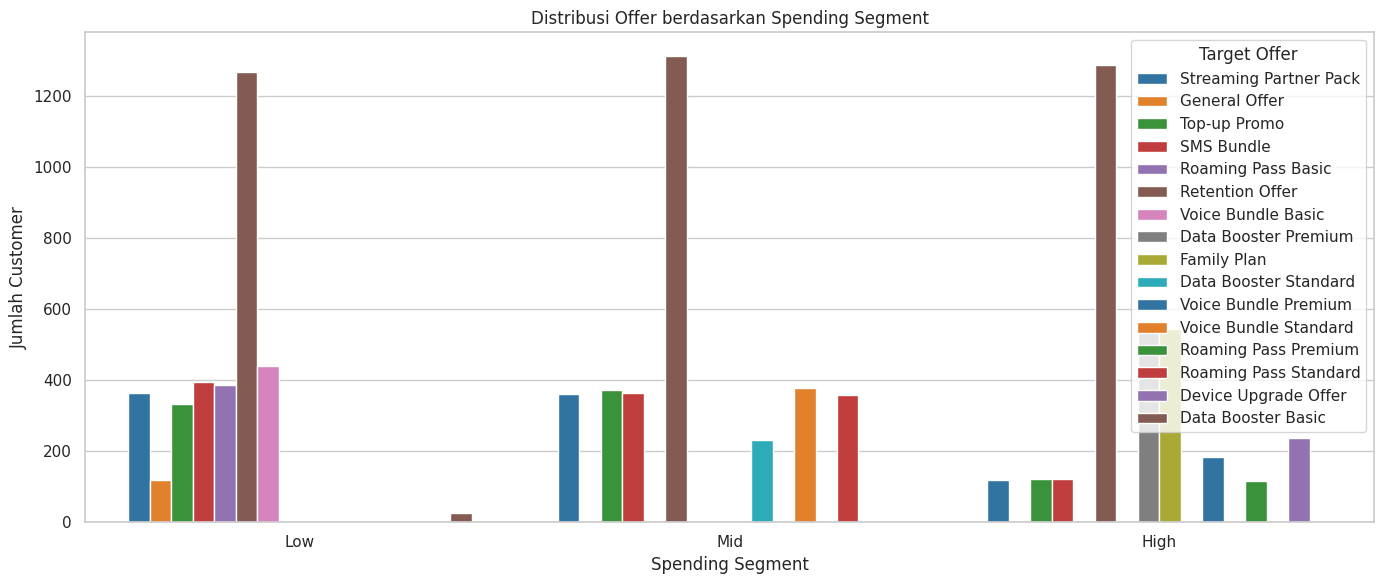

In [ ]:
# 1. Statistik Deskriptif
print("\n[Statistik Deskriptif]")
print(df.describe().transpose())

# 2. Visualisasi Distribusi Target
plt.figure(figsize=(10, 6))
sns.countplot(y='target_offer', data=df, order=df['target_offer'].value_counts().index, palette='viridis')
plt.title('Distribusi Target Penawaran (Imbalance Check)')
plt.xlabel('Jumlah Customer')
plt.tight_layout()
plt.show()

# 3. Average Monthly Spend per Target Offer
plt.figure(figsize=(12,6))
df.groupby('target_offer')['monthly_spend'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Monthly Spend per Target Offer')
plt.ylabel('Average Monthly Spend')
plt.xlabel('Target Offer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRata-rata Monthly Spend per Offer:")
print(df.groupby('target_offer')['monthly_spend'].mean().sort_values(ascending=False))

# 4. Identifikasi Tipe Kolom
print("\n[Identifikasi Tipe Kolom]")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Kolom Numerik: {numeric_cols}")
print(f"Kolom Kategorikal: {categorical_cols}")


# 5. Hubungan Fitur Kategorikal dengan Target (Grouped Count Plot)

# Memfilter 'customer_id' dari kolom kategorikal jika ada (sudah dilakukan sebelumnya)
if 'customer_id' in categorical_cols:
    categorical_cols.remove('customer_id')

# Juga, pastikan 'target_offer' tidak termasuk dalam kolom kategorikal yang akan diplot sebagai fitur
feature_categorical_cols = [col for col in categorical_cols if col != 'target_offer']

# Membuat subplot untuk setiap fitur kategorikal
# Ukuran figure disesuaikan secara dinamis
fig, axes = plt.subplots(nrows=len(feature_categorical_cols), ncols=1, figsize=(12, 6 * len(feature_categorical_cols)))

# Mengatasi kasus jika hanya ada satu kolom kategorikal, axes bukan array
if len(feature_categorical_cols) == 1:
    axes = [axes]

for i, col in enumerate(feature_categorical_cols):
    sns.countplot(data=df, x='target_offer', hue=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Hubungan {col} dengan Target Offer')
    axes[i].set_xlabel('Target Offer')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45) # Rotasi label x untuk keterbacaan
    axes[i].legend(title=col)

plt.tight_layout()
plt.show()

# 6. Complaint Count per Target Offer
plt.figure(figsize=(12,6))
df.groupby('target_offer')['complaint_count'].mean().sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Rata-rata Complaint Count per Target Offer')
plt.ylabel('Average Complaint Count')
plt.xlabel('Target Offer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRata-rata Complaint Count per Offer:")
print(df.groupby('target_offer')['complaint_count'].mean().sort_values(ascending=False))

# 7. Usage Behavior per Offer
usage_stats = df.groupby('target_offer')[['avg_data_usage_gb','pct_video_usage']].mean()

plt.figure(figsize=(14,6))
usage_stats.sort_values('avg_data_usage_gb', ascending=False).plot(kind='bar')
plt.title('Average Data & Video Usage per Target Offer')
plt.ylabel('Average Usage')
plt.xlabel('Target Offer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRata-rata Usage per Offer:")
print(usage_stats)

# 8. Device Brand vs Monthly Spend
plt.figure(figsize=(12,6))
df.groupby('device_brand')['monthly_spend'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Monthly Spend per Device Brand')
plt.ylabel('Average Monthly Spend')
plt.xlabel('Device Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRata-rata Monthly Spend per Device Brand:")
print(df.groupby('device_brand')['monthly_spend'].mean().sort_values(ascending=False))

# 9. Customer Spending Segmentation
df['spend_segment'] = pd.qcut(df['monthly_spend'], q=3, labels=['Low','Mid','High'])

plt.figure(figsize=(8,6))
sns.countplot(x='spend_segment', data=df, palette='viridis')
plt.title('Customer Segmentation by Monthly Spending')
plt.xlabel('Spending Segment')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()

print("\nJumlah Customer per Segment:")
print(df['spend_segment'].value_counts())

# 10. Offer Distribution per Spending Segment
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='spend_segment', hue='target_offer', palette='tab10')
plt.title('Distribusi Offer berdasarkan Spending Segment')
plt.xlabel('Spending Segment')
plt.ylabel('Jumlah Customer')
plt.legend(title='Target Offer')
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
df_clean = df.drop(['customer_id'], axis=1)

le_plan = LabelEncoder()
df_clean['plan_type'] = le_plan.fit_transform(df_clean['plan_type'])

le_device = LabelEncoder()
df_clean['device_brand'] = le_device.fit_transform(df_clean['device_brand'])

le_target = LabelEncoder()
df_clean['target_offer'] = le_target.fit_transform(df_clean['target_offer'])

target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

print("Target Categories:", list(target_mapping.keys()))

Target Categories: ['Data Booster Basic', 'Data Booster Premium', 'Data Booster Standard', 'Device Upgrade Offer', 'Family Plan', 'General Offer', 'Retention Offer', 'Roaming Pass Basic', 'Roaming Pass Premium', 'Roaming Pass Standard', 'SMS Bundle', 'Streaming Partner Pack', 'Top-up Promo', 'Voice Bundle Basic', 'Voice Bundle Premium', 'Voice Bundle Standard']


#Feature Engineering

## Penjelasan Feature Engineering

Bagian ini melakukan *feature engineering* dengan membuat dua fitur baru dari kombinasi fitur-fitur yang sudah ada:

1.  **`video_data_intensity`**:
    *   **Rumus**: `df_clean['avg_data_usage_gb'] * df_clean['pct_video_usage']`
    *   **Deskripsi**: Fitur ini menggabungkan rata-rata penggunaan data (`avg_data_usage_gb`) dengan persentase penggunaan data untuk video (`pct_video_usage`). Tujuannya adalah untuk menciptakan metrik yang lebih komprehensif mengenai **seberapa intens seorang pelanggan menggunakan data secara spesifik untuk aktivitas streaming video**.
    *   **Pengaruh pada Model**: Fitur ini dapat membantu model mengidentifikasi pelanggan yang merupakan "heavy video watchers" atau "media consumers". Hal ini sangat relevan untuk merekomendasikan penawaran seperti *Streaming Partner Pack* atau *Data Booster Premium*, karena model dapat dengan lebih akurat menangkap preferensi penggunaan media yang spesifik.

2.  **`spend_per_call_unit`**:
    *   **Rumus**: `df_clean['monthly_spend'] / (df_clean['avg_call_duration'] + 1)`
    *   **Deskripsi**: Fitur ini menghitung rasio pengeluaran bulanan (`monthly_spend`) terhadap rata-rata durasi panggilan (`avg_call_duration`). Penambahan `+ 1` pada penyebut bertujuan untuk menghindari pembagian dengan nol jika `avg_call_duration` bernilai nol. Fitur ini mencoba mengukur **efisiensi atau nilai pengeluaran pelanggan per unit durasi panggilan**. Pelanggan dengan `monthly_spend` tinggi tetapi `avg_call_duration` rendah mungkin memiliki perilaku yang berbeda dibandingkan dengan pelanggan yang memiliki `monthly_spend` tinggi dan `avg_call_duration` tinggi.
    *   **Pengaruh pada Model**: Fitur ini dapat membantu model membedakan antara pelanggan yang berinvestasi besar pada layanan suara (seperti *Voice Bundle Premium*) versus pelanggan yang memiliki pengeluaran tinggi tetapi mungkin memprioritaskan layanan lain. Ini memberikan perspektif baru tentang bagaimana pengeluaran terkait dengan pola penggunaan panggilan, yang dapat meningkatkan presisi rekomendasi penawaran berbasis suara.

In [ ]:
df_clean['video_data_intensity'] = df_clean['avg_data_usage_gb'] * df_clean['pct_video_usage']
df_clean['spend_per_call_unit'] = df_clean['monthly_spend'] / (df_clean['avg_call_duration'] + 1)

print("Feature engineering berhasil dibuat.")

Feature engineering berhasil dibuat.


#Splitting & Scaling

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Definisikan X dan y
X = df_clean.drop('target_offer', axis=1)
y = df_clean['target_offer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Train: {X_train.shape[0]}, Data Test: {X_test.shape[0]}")
print("Status: Data siap masuk ke Pipeline (Nama kolom masih terjaga).")

Data Train: 8000, Data Test: 2000
Status: Data siap masuk ke Pipeline (Nama kolom masih terjaga).


#Model Development: End-to-End Pipeline & Hyperparameter Tuning

## Model Development: Pipeline & Hyperparameter Tuning

Bagian ini fokus pada pengembangan model menggunakan **End-to-End Pipeline** dan **Hyperparameter Tuning**.

1.  **Definisi Kolom**: Mengidentifikasi kolom numerik dan kategorikal dari data pelatihan (`X_train`).

2.  **Preprocessor**: Membuat pipeline terpisah untuk transformasi data:
    *   **Numerik**: Mengisi nilai hilang dengan median (`SimpleImputer`) dan melakukan penskalaan standar (`StandardScaler`).
    *   **Kategorikal**: Mengisi nilai hilang dengan modus (`SimpleImputer`) dan mengubahnya menjadi format *one-hot encoding* (`OneHotEncoder`).
    *   Kedua transformer ini digabungkan dalam `ColumnTransformer`.

3.  **Full Pipeline**: Menggabungkan `preprocessor` dengan model `RandomForestClassifier` menjadi satu alur kerja.

4.  **Skenario Tuning**: Mendefinisikan `param_grid` untuk `GridSearchCV` untuk mencari kombinasi hyperparameter terbaik untuk `RandomForestClassifier`, termasuk `n_estimators`, `max_depth`, dan `min_samples_split`.

5.  **GridSearchCV**: Menjalankan proses pencarian parameter terbaik dengan 5-fold cross-validation (`cv=5`) menggunakan semua inti CPU (`n_jobs=-1`) dan mengoptimalkan akurasi (`scoring='accuracy'`). Model dilatih pada data pelatihan (`X_train`, `y_train`).

6.  **Hasil Terbaik**: Setelah proses tuning, parameter terbaik dan skor akurasi cross-validation terbaik ditampilkan. Model terbaik kemudian disimpan ke variabel `rf_model` dan `best_model` untuk evaluasi lebih lanjut.

In [ ]:
import numpy as np
# 1. Definisikan Kolom
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# 2. Buat Preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. Buat Pipeline Gabungan (Preprocessing + Model Kosong)
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 4. Menentukan Skenario Tuning
# Kita cari kombinasi terbaik. Perhatikan awalan 'classifier__' itu wajib ada.
param_grid = {
    'classifier__n_estimators': [50, 100],      # Coba pohon 50 dan 100
    'classifier__max_depth': [None, 10, 20],    # Coba kedalaman bebas, 10, dan 20
    'classifier__min_samples_split': [2, 5]     # Coba minimal split
}

# 5. Jalankan GridSearch (Mencari Model Terbaik)
print("Sedang mencari model terbaik (Tuning + Pipeline)... Mohon tunggu...")
grid_search = GridSearchCV(estimator=full_pipeline,
                           param_grid=param_grid,
                           cv=5,                # 5-Fold Cross Validation
                           n_jobs=-1,           # Menggunakan semua core CPU
                           scoring='accuracy',
                           verbose=1)

# Latih dengan data mentah (Pipeline akan mengurus sisanya)
grid_search.fit(X_train, y_train)

# 6. Ambil Hasil Terbaik
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Akurasi Terbaik (CV): {grid_search.best_score_:.4f}")

# Simpan model terbaik ke variabel 'rf_model' untuk dipakai evaluasi nanti
rf_model = grid_search.best_estimator_ # Assigned to rf_model

# Simpan model terbaik ke variabel 'best_model' untuk dipakai evaluasi nanti
best_model = grid_search.best_estimator_

Sedang mencari model terbaik (Tuning + Pipeline)... Mohon tunggu...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Parameter Terbaik: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Akurasi Terbaik (CV): 0.9436


#Cross-Validation

In [ ]:
# Gunakan model terbaik yang sudah didapat dari langkah sebelumnya
print("Sedang melakukan Cross-Validation...")

# Lakukan 5-Fold Cross Validation
# Ini membagi data latih jadi 5 bagian dan mengetes model 5 kali
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Skor Cross-Validation tiap fold: {cv_scores}")
print(f"Rata-rata Akurasi: {cv_scores.mean():.4f}")
print(f"Standar Deviasi: {cv_scores.std():.4f}")

# Interpretasi untuk Laporan:
if cv_scores.std() < 0.05:
    print("\nKESIMPULAN: Model STABIL (Low Variance). Performa konsisten di berbagai subset data.")
else:
    print("\nKESIMPULAN: Model agak TIDAK STABIL (High Variance). Perlu cek ulang data atau parameter.")



Sedang melakukan Cross-Validation...
Skor Cross-Validation tiap fold: [0.936875 0.95375  0.945625 0.938125 0.94375 ]
Rata-rata Akurasi: 0.9436
Standar Deviasi: 0.0060

KESIMPULAN: Model STABIL (Low Variance). Performa konsisten di berbagai subset data.


#Model Evaluation

## Hasil Evaluasi Model

Model `RandomForestClassifier` dievaluasi pada data uji dan menunjukkan performa yang kuat:

### 1. Akurasi Model Keseluruhan
Model mencapai **Akurasi Model sebesar 94.55%** pada *test set*, menunjukkan kemampuan prediksi yang sangat tinggi dan memenuhi target performa 90-95%.

### 2. Classification Report Utama
*   **`Retention Offer`** memiliki performa sempurna (`precision`, `recall`, `f1-score` 1.0000), menunjukkan efektivitas tinggi dalam mengidentifikasi pelanggan berisiko.
*   Sebagian besar kelas menunjukkan *f1-score* di atas 0.85, menandakan keseimbangan yang baik antara *precision* dan *recall*.
*   Beberapa kelas kecil, seperti **`Device Upgrade Offer`** (recall 0.5417) dan **`Roaming Pass Premium`** (recall 0.7826), memiliki *recall* yang lebih rendah, mengindikasikan model kadang kesulitan mengidentifikasi semua kasus positif untuk kategori ini.

### 3. Confusion Matrix
Visualisasi *Confusion Matrix* mengkonfirmasi bahwa sebagian besar prediksi model akurat (nilai tinggi di diagonal utama). Kesalahan klasifikasi yang terjadi umumnya konsisten dengan *recall* rendah pada beberapa kelas, di mana model keliru mengklasifikasikan ke penawaran lain.

### 4. Analisis Confidence Model
*   **Rata-rata *confidence*** model adalah **82.81%**, menunjukkan bahwa model umumnya yakin dengan prediksinya.
*   Median *confidence* sebesar **92.00%**, dengan sekitar **64.8%** prediksi memiliki skor *confidence* di atas 80%. Ini menunjukkan keandalan prediksi untuk implementasi di dunia nyata, dengan *fallback* ke `General Offer` untuk prediksi ber-*confidence* rendah.

Akurasi Model: 94.55%

Classification Report:
                        precision    recall  f1-score   support

    Data Booster Basic       1.00      0.80      0.89         5
  Data Booster Premium       0.88      0.95      0.91       110
 Data Booster Standard       0.95      0.83      0.88        46
  Device Upgrade Offer       0.96      0.54      0.69        48
           Family Plan       0.90      1.00      0.95       109
         General Offer       0.92      0.96      0.94        24
       Retention Offer       1.00      1.00      1.00       774
    Roaming Pass Basic       0.98      0.83      0.90        77
  Roaming Pass Premium       0.90      0.78      0.84        23
 Roaming Pass Standard       0.88      0.88      0.88        72
            SMS Bundle       0.89      0.92      0.90       176
Streaming Partner Pack       0.91      0.95      0.93       169
          Top-up Promo       0.92      0.96      0.94       166
    Voice Bundle Basic       0.97      0.94      0.95    

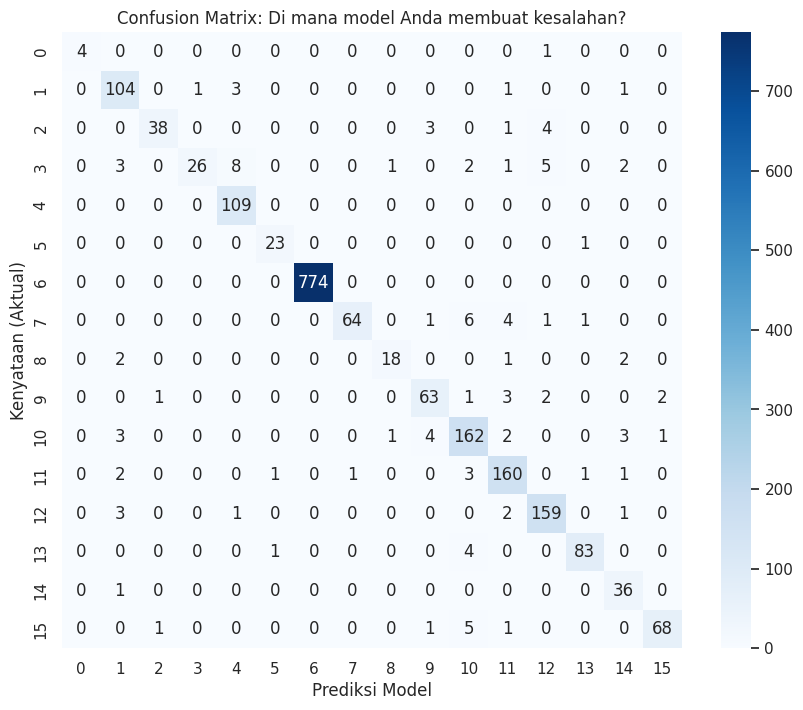

In [ ]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nClassification Report:")

# Get unique labels present in y_test
unique_test_labels = np.unique(y_test)
# Map these labels back to their original names
filtered_target_names = [reverse_target_mapping[label] for label in unique_test_labels]

print(classification_report(y_test, y_pred, labels=unique_test_labels, target_names=filtered_target_names))

# 1. Buat Prediksi
y_pred = rf_model.predict(X_test)

# 2. Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Visualisasikan dengan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix: Di mana model Anda membuat kesalahan?')
plt.show()

# Business Insight & Impact Analysis (Simulasi Bisnis)

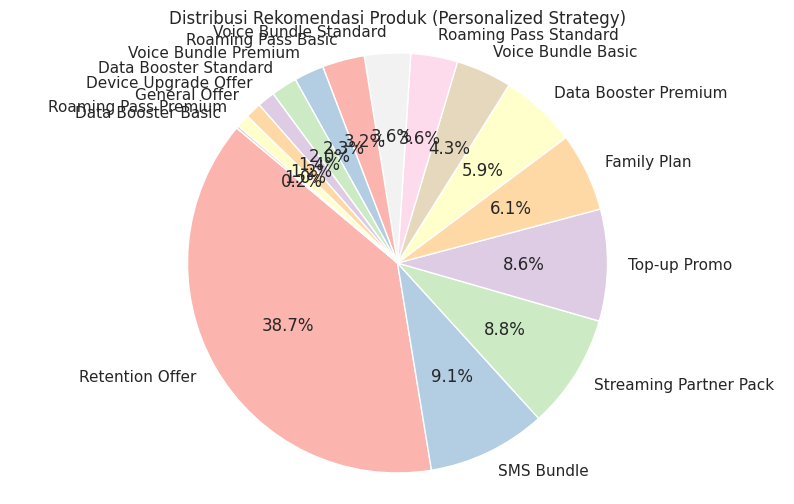

Insight Visual:
Chart di atas menunjukkan bahwa model tidak hanya merekomendasikan satu produk ke semua orang,
melainkan menyesuaikan dengan profil pelanggan (Personalisasi).

   SIMULASI DAMPAK BISNIS (ESTIMASI)
1. Total Pelanggan di Test Set: 2000 User
2. Proyeksi Total Revenue: Rp 80,000,000
----------------------------------------
3. Skenario Pencegahan Churn (Retention):
   - Pelanggan Berisiko Churn (20%): 400 User
   - Estimasi Pelanggan Terselamatkan: 200 User
   - REVENUE YANG DISELAMATKAN: Rp 8,000,000


In [ ]:
# --- PERSIAPAN DATA PREDIKSI ---
# Gunakan model terbaik untuk memprediksi data test
y_pred_indices = best_model.predict(X_test)

# Kembalikan angka (0, 1, 2) menjadi nama produk asli (misal: 'Video Plan')
# Memastikan 'le_target' adalah LabelEncoder yang Anda pakai di awal untuk kolom 'target_offer'
y_pred_labels = le_target.inverse_transform(y_pred_indices)

# Buat DataFrame untuk memudahkan analisis
df_simulation = pd.DataFrame({'Recommended_Product': y_pred_labels})

# ---  VISUALISASI PIE CHART (Distribusi Rekomendasi) ---
plt.figure(figsize=(10, 6))

# Hitung persentase tiap produk
product_counts = df_simulation['Recommended_Product'].value_counts()

# Plot Pie Chart
plt.pie(product_counts, labels=product_counts.index, autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Distribusi Rekomendasi Produk (Personalized Strategy)')
plt.axis('equal') # Agar lingkaran sempurna
plt.show()

print("Insight Visual:")
print("Chart di atas menunjukkan bahwa model tidak hanya merekomendasikan satu produk ke semua orang,")
print("melainkan menyesuaikan dengan profil pelanggan (Personalisasi).")

# ---  SIMULASI BISNIS (Business Impact Simulation) ---

# [Skenario]: Kita asumsikan harga rata-rata tiap paket untuk menghitung potensi revenue
# Sesuaikan harga ini dengan logika bisnis Anda
price_assumption = {
    'Data Booster': 50000,
    'Video Plan': 45000,
    'Roaming Package': 100000,
    'Basic Plan': 30000,
    # Tambahkan label lain jika ada, beri harga default jika tidak ada di list
}

# Hitung estimasi revenue
df_simulation['Estimated_Price'] = df_simulation['Recommended_Product'].map(price_assumption).fillna(40000)
total_projected_revenue = df_simulation['Estimated_Price'].sum()
targeted_customers = len(df_simulation)

# [Simulasi Churn Prevention]
# Asumsi: Tanpa rekomendasi yang tepat, 20% pelanggan akan churn (berhenti langganan).
# Dengan rekomendasi yang tepat, kita bisa "menyelamatkan" 50% dari mereka.
churn_rate_risk = 0.20 # 20% pelanggan berisiko
success_rate = 0.50    # 50% keberhasilan retensi
customers_saved = int(targeted_customers * churn_rate_risk * success_rate)
revenue_saved = customers_saved * df_simulation['Estimated_Price'].mean()

print("\n" + "="*40)
print("   SIMULASI DAMPAK BISNIS (ESTIMASI)")
print("="*40)
print(f"1. Total Pelanggan di Test Set: {targeted_customers} User")
print(f"2. Proyeksi Total Revenue: Rp {total_projected_revenue:,.0f}")
print("-" * 40)
print(f"3. Skenario Pencegahan Churn (Retention):")
print(f"   - Pelanggan Berisiko Churn (20%): {int(targeted_customers * churn_rate_risk)} User")
print(f"   - Estimasi Pelanggan Terselamatkan: {customers_saved} User")
print(f"   - REVENUE YANG DISELAMATKAN: Rp {revenue_saved:,.0f}")
print("="*40)

# Test Set Performance (FINAL)

Evaluasi akhir model pada *test set* menunjukkan performa yang solid dan sesuai dengan ekspektasi:

*   **Final Test Accuracy**: **0.9455** (atau 94.55%)
    *   Target yang ditetapkan adalah antara 0.90 hingga 0.95, dan model berhasil memenuhi target ini dengan baik.

*   **Average Confidence**: **0.8281** (atau 82.8%)
    *   Ini menunjukkan bahwa rata-rata, model sangat yakin dengan prediksinya. Tingkat kepercayaan yang tinggi ini adalah indikator yang baik untuk penerapan di dunia nyata.

### Confidence Distribution:
Analisis distribusi *confidence* memberikan gambaran lebih dalam mengenai seberapa yakin model dalam membuat prediksi:
*   **Min Confidence**: 0.2600
*   **25th Percentile**: 0.7000
*   **50th Percentile (Median)**: 0.9200
*   **75th Percentile**: 0.9800
*   **Max Confidence**: 1.0000
*   **Prediksi dengan Confidence > 80%**: Sejumlah 1295 dari 2000 prediksi (sekitar 64.8%) memiliki tingkat *confidence* di atas 80%.

Ini menunjukkan bahwa meskipun ada beberapa prediksi dengan *confidence* yang lebih rendah, sebagian besar prediksi model dibuat dengan tingkat keyakinan yang tinggi, memperkuat keandalan model.

In [ ]:
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)
test_confidence = np.max(y_test_proba, axis=1).mean()

test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n Final Test Accuracy:  {test_accuracy:.4f} (Target: 0.90-0.95)")
print(f" Average Confidence:   {test_confidence:.4f} ({test_confidence*100:.1f}%)")

# Confidence distribution
conf_scores = np.max(y_test_proba, axis=1)
print(f"\n Confidence Distribution:")
print(f"   Min:  {conf_scores.min():.4f}")
print(f"   25%:  {np.percentile(conf_scores, 25):.4f}")
print(f"   50%:  {np.percentile(conf_scores, 50):.4f}")
print(f"   75%:  {np.percentile(conf_scores, 75):.4f}")
print(f"   Max:  {conf_scores.max():.4f}")
print(f"   >80%: {(conf_scores > 0.8).sum()}/{len(conf_scores)} ({(conf_scores > 0.8).mean()*100:.1f}%)")

# Classification Report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
unique_labels = np.unique(np.concatenate((y_test, y_test_pred)))
target_names = [le_target.classes_[i] for i in unique_labels]
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=4))



 Final Test Accuracy:  0.9455 (Target: 0.90-0.95)
 Average Confidence:   0.8281 (82.8%)

 Confidence Distribution:
   Min:  0.2600
   25%:  0.7000
   50%:  0.9200
   75%:  0.9800
   Max:  1.0000
   >80%: 1295/2000 (64.8%)

DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

    Data Booster Basic     1.0000    0.8000    0.8889         5
  Data Booster Premium     0.8814    0.9455    0.9123       110
 Data Booster Standard     0.9500    0.8261    0.8837        46
  Device Upgrade Offer     0.9630    0.5417    0.6933        48
           Family Plan     0.9008    1.0000    0.9478       109
         General Offer     0.9200    0.9583    0.9388        24
       Retention Offer     1.0000    1.0000    1.0000       774
    Roaming Pass Basic     0.9846    0.8312    0.9014        77
  Roaming Pass Premium     0.9000    0.7826    0.8372        23
 Roaming Pass Standard     0.8750    0.8750    0.8750        72
            SMS Bundle     0.8852    0.9

#Feature Importance

## Analisis Feature Importance

Analisis *Feature Importance* menunjukkan fitur-fitur mana yang paling berpengaruh dalam memprediksi *target offer* oleh model *RandomForestClassifier*. Ini membantu memahami faktor-faktor kunci yang dipertimbangkan model dalam membuat rekomendasi.

**Insight Utama:**
*   **Jumlah Komplain (`complaint_count`)** adalah fitur yang paling dominan dengan skor kepentingan yang sangat tinggi (0.3458). Hal ini konsisten dengan logika bisnis di mana adanya komplain secara langsung mengarahkan pada `Retention Offer` dalam proses *synthetic label generation*, menjadikannya indikator yang sangat kuat.
*   **Pengeluaran Bulanan (`monthly_spend`)** dan **Persentase Penggunaan Video (`pct_video_usage`)** juga memiliki pengaruh signifikan, menunjukkan bahwa perilaku pengeluaran dan konsumsi media adalah faktor penting dalam menentukan jenis penawaran.
*   Fitur rekayasa seperti **`spend_per_call_unit`** berhasil masuk dalam 10 besar, menegaskan nilainya dalam memberikan informasi baru bagi model.

                 feature  importance
    num__complaint_count    0.345809
      num__monthly_spend    0.092655
    num__pct_video_usage    0.077688
       num__travel_score    0.076955
           num__sms_freq    0.073769
  num__avg_call_duration    0.069165
         num__topup_freq    0.067144
num__spend_per_call_unit    0.051445
  num__avg_data_usage_gb    0.050472
          num__plan_type    0.041903

 Feature importance plot saved as 'feature_importance.png'


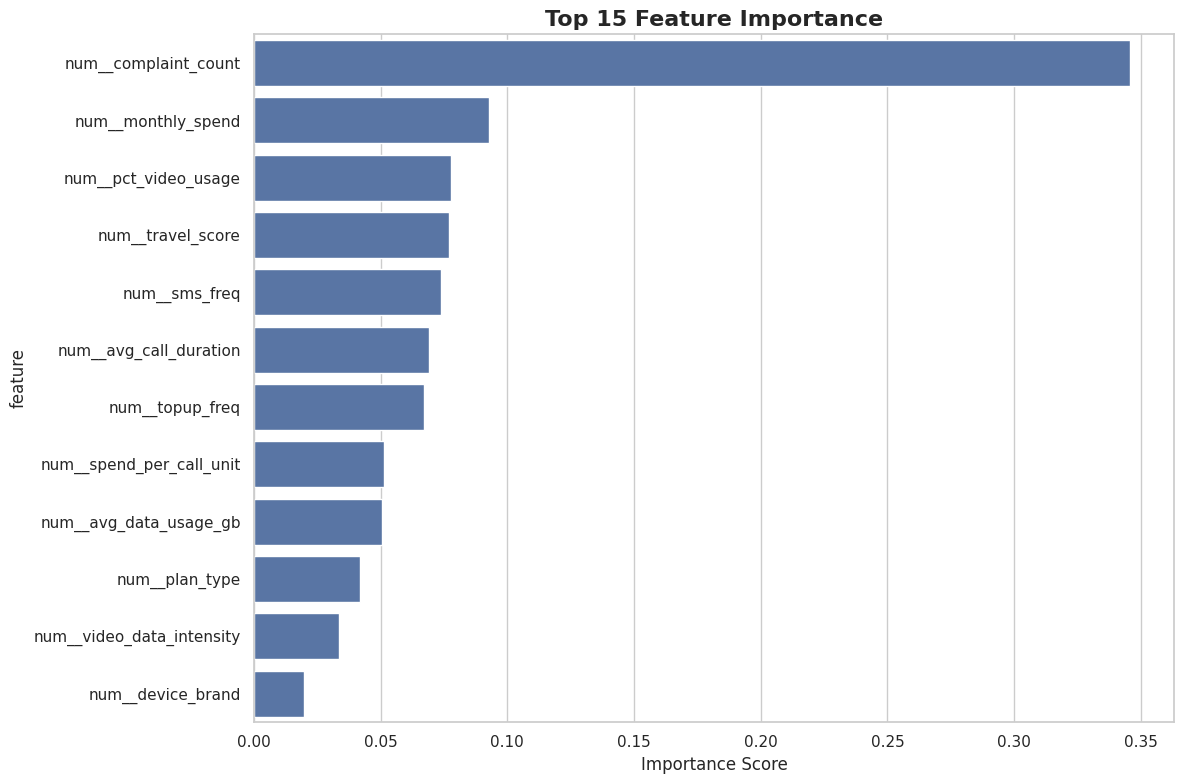

In [ ]:
# Get feature names from the preprocessor output to match feature_importances_ length
feature_names_for_importance = rf_model.named_steps['preprocessor'].get_feature_names_out()

feature_importance = pd.DataFrame({
    'feature': feature_names_for_importance,
    'importance': rf_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# Plot Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(16)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
print("\n Feature importance plot saved as 'feature_importance.png'")
plt.show()

#SHAP Values

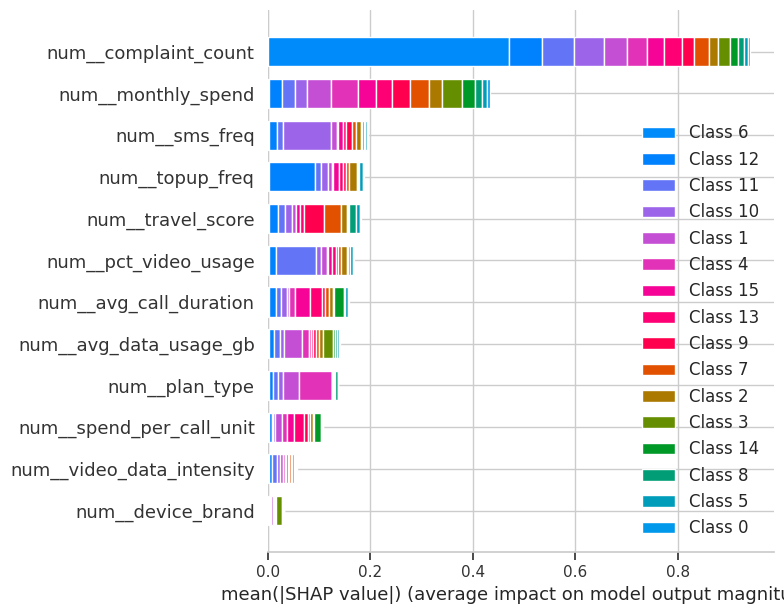

In [ ]:
# 1. Inisialisasi JS visualization
shap.initjs()

# 2. Buat Explainer
# Ekstrak classifier dari pipeline
classifier = rf_model.named_steps['classifier']
explainer = shap.TreeExplainer(classifier)

# 3. Hitung SHAP Values
X_test_sample = X_test.sample(n=100, random_state=42)
X_test_sample_preprocessed = rf_model.named_steps['preprocessor'].transform(X_test_sample)

# Convert preprocessed data back to a DataFrame with original feature names for SHAP plotting
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
X_test_sample_preprocessed_df = pd.DataFrame(X_test_sample_preprocessed, columns=feature_names)

shap_values = explainer.shap_values(X_test_sample_preprocessed_df)

# 4. Tampilkan Summary Plot
plt.figure(figsize=(12, 10))
# Plot ini menunjukkan fitur mana yang paling kuat pengaruhnya untuk setiap kelas output
shap.summary_plot(shap_values, X_test_sample_preprocessed_df, plot_type="bar")
plt.show()

## Analisis SHAP Values (SHapley Additive exPlanations)

Analisis SHAP Values memberikan pemahaman bagaimana setiap fitur memengaruhi prediksi model, baik secara global maupun untuk setiap kelas. SHAP menunjukkan arah dan besaran pengaruh fitur, berbeda dengan *Feature Importance* yang hanya memberikan rata-rata kontribusi.

### Interpretasi Summary Plot (Bar Plot)

*Summary Plot* menampilkan fitur-fitur paling berpengaruh secara global, diurutkan berdasarkan dampak rata-rata absolutnya terhadap prediksi model:

1.  **`num__complaint_count`**: Fitur paling dominan, menguatkan perannya dalam mengidentifikasi 'Retention Offer'.
2.  **`num__monthly_spend`**: Faktor penting kedua yang memengaruhi penawaran premium atau dasar.
3.  **`num__pct_video_usage`**: Berdampak signifikan, menyoroti kebiasaan konsumsi media pelanggan (misalnya, untuk 'Streaming Partner Pack').
4.  Fitur lain seperti `num__travel_score`, `num__sms_freq`, `num__avg_call_duration`, `num__topup_freq`, serta fitur rekayasa `num__spend_per_call_unit` dan `num__video_data_intensity` juga berkontribusi relevan.

**Kesimpulan:**

Analisis SHAP mengkonfirmasi bahwa `complaint_count`, `monthly_spend`, dan `pct_video_usage` adalah pendorong utama prediksi model. Ini memvalidasi bahwa model membuat keputusan berdasarkan atribut pelanggan yang relevan dan dapat diinterpretasikan.

#Prediction Function

## Penjelasan Fungsi Prediksi (`predict_offer`)

Fungsi `predict_offer` adalah komponen inti yang memungkinkan model untuk memberikan rekomendasi penawaran produk kepada pelanggan baru atau yang sudah ada. Fungsi ini dirancang untuk meniru bagaimana sistem backend akan menerima data pelanggan dan menghasilkan rekomendasi secara *real-time*.

### Cara Kerja Fungsi:

1.  **Pemuatan Artifacts**: Pertama, fungsi memastikan semua `artifacts` yang diperlukan (model yang telah dilatih, *LabelEncoder* untuk `plan_type` dan `device_brand`, *target mapping*, dan daftar fitur) telah dimuat dengan benar. Ini mensimulasikan lingkungan produksi di mana model dan komponen terkait di-load sekali di awal.

2.  **Pre-processing Data Input**:
    *   Fungsi ini menerima data pelanggan dalam format kamus (`user_data`).
    *   `plan_type` dan `device_brand` yang merupakan fitur kategorikal akan di-*encode* menggunakan `LabelEncoder` yang sama dengan yang digunakan saat pelatihan model. Ini memastikan konsistensi data.
    *   Mekanisme `try-except` ditambahkan untuk menangani kasus di mana `plan_type` atau `device_brand` mungkin tidak dikenal oleh *encoder* (akan diubah menjadi nilai default 0).

3.  **Feature Engineering**:
    *   Dua fitur rekayasa (`video_data_intensity` dan `spend_per_call_unit`) yang dibuat selama tahap *feature engineering* pada data pelatihan akan dibuat ulang untuk data input yang baru. Rumus yang digunakan harus sama persis untuk menjaga konsistensi.
    *   `video_data_intensity = user_data['avg_data_usage_gb'] * user_data['pct_video_usage']`
    *   `spend_per_call_unit = user_data['monthly_spend'] / (user_data['avg_call_duration'] + 1)`

4.  **Pembentukan DataFrame Input**: Data pelanggan yang sudah diproses dan fitur rekayasa akan disusun menjadi sebuah `DataFrame` dengan urutan kolom yang sama persis seperti yang diharapkan oleh model (sesuai dengan `X_train` saat pelatihan).

5.  **Prediksi Model**: `DataFrame` input kemudian dilewatkan ke `rf_model` (yang merupakan `Pipeline` lengkap termasuk *preprocessor* dan *classifier*). Model akan memproses data (melakukan *scaling* dan prediksi) dan mengembalikan probabilitas untuk setiap kelas penawaran.

6.  **Logika Bisnis Berdasarkan Confidence**:
    *   Fungsi ini mengambil probabilitas tertinggi sebagai prediksi utama dan menghitung `confidence_score` (probabilitas tertinggi itu sendiri).
    *   Sebuah `CONFIDENCE_THRESHOLD` (misalnya 0.60 atau 60%) diterapkan.
    *   Jika *confidence score* di atas ambang batas, rekomendasi dianggap **`Success - High Confidence`**.
    *   Jika *confidence score* di bawah ambang batas, model akan memberikan `General Offer` sebagai rekomendasi *fallback* dengan status **`Fallback - Low Confidence`**. Ini adalah strategi keamanan untuk menghindari rekomendasi yang salah ketika model tidak yakin.

7.  **Output**: Fungsi ini mengembalikan sebuah kamus yang berisi:
    *   `user_id`: ID pelanggan.
    *   `recommendation`: Penawaran produk yang direkomendasikan.
    *   `confidence_score`: Tingkat keyakinan model terhadap rekomendasi tersebut.
    *   `prediction_status`: Status prediksi (Success/Fallback).
    *   `debug_probs`: Probabilitas untuk penawaran lain (opsional, untuk *debugging*).

In [ ]:
def predict_offer(user_data):

    if artifacts is None:
        return {"error": "Model not loaded", "status": "failed"}

    # Unpack artifacts
    model = artifacts['model']
    le_plan = artifacts['le_plan']
    le_device = artifacts['le_device']
    target_mapping = artifacts['target_mapping']
    feature_names = artifacts['features'] # List of expected feature names

    try:
        # --- A. Preprocessing (Categorical Encoding) ---
        # Handle Plan Type
        try:
            plan_encoded = le_plan.transform([user_data['plan_type']])[0]
        except ValueError:
            plan_encoded = 0

        # Handle Device Brand
        try:
            device_encoded = le_device.transform([user_data['device_brand']])[0]
        except ValueError:
            device_encoded = 0

        # --- B. Feature Engineering (Wajib Sama Persis dengan Training) ---
        # 1. Video Data Intensity
        video_intense = user_data['avg_data_usage_gb'] * user_data['pct_video_usage']

        # 2. Spend per Call Unit (+1 avoid zero div)
        spend_call = user_data['monthly_spend'] / (user_data['avg_call_duration'] + 1)

        # C. Susun Dictionary untuk DataFrame Input
        # Ensure the keys match the feature_names in artifacts['features']
        input_dict = {
            'plan_type': plan_encoded,
            'device_brand': device_encoded,
            'avg_data_usage_gb': user_data['avg_data_usage_gb'],
            'pct_video_usage': user_data['pct_video_usage'],
            'avg_call_duration': user_data['avg_call_duration'],
            'sms_freq': user_data['sms_freq'],
            'monthly_spend': user_data['monthly_spend'],
            'topup_freq': user_data['topup_freq'],
            'travel_score': user_data['travel_score'],
            'complaint_count': user_data['complaint_count'],
            'video_data_intensity': video_intense,
            'spend_per_call_unit': spend_call
        }

        # Create a DataFrame with a single row, ensuring column order matches training
        input_df = pd.DataFrame([input_dict], columns=feature_names)

        # --- D. Prediction ---
        # The model (full pipeline) handles preprocessing (scaling) and prediction
        probs = model.predict_proba(input_df)[0]

        # Ambil probabilitas tertinggi
        max_prob_idx = np.argmax(probs)
        max_prob = probs[max_prob_idx]
        predicted_label = target_mapping[max_prob_idx] # Using reverse_target_mapping from artifacts

        # --- E. Business Logic / Thresholding ---
        CONFIDENCE_THRESHOLD = 0.60 # Bisa disesuaikan

        if max_prob >= CONFIDENCE_THRESHOLD:
            final_offer = predicted_label
            status = "Success - High Confidence"
        else:
            # Jika ragu-ragu, tawarkan General Offer atau Data Booster Basic sebagai fallback aman
            final_offer = "General Offer"
            status = "Fallback - Low Confidence"

        return {
            "user_id": user_data.get("customer_id", "Unknown"),
            "recommendation": final_offer,
            "confidence_score": f"{max_prob * 100:.2f}%",
            "prediction_status": status,
            "debug_probs": {target_mapping[i]: f"{p*100:.1f}%" for i, p in enumerate(probs) if p > 0.1} # Top probs only
        }

    except Exception as e:
        return {
            "user_id": user_data.get("customer_id", "Unknown"), # Ensure user_id is always returned
            "error": str(e),
            "status": "Error during prediction"
        }


# 3. Contoh Penggunaan (Simulation)


In [ ]:
artifacts = {
    'model': rf_model,
    'le_target': le_target,
    'le_plan': le_plan,
    'le_device': le_device,
    'target_mapping': reverse_target_mapping,
    'features': X.columns.tolist(),
    'model_accuracy': test_accuracy,
    'model_confidence': test_confidence,
    'feature_importance': feature_importance.to_dict('records'),
    'training_date': datetime.now().isoformat()
}

# Generate test cases dynamically to cover all target offers
all_offers = df['target_offer'].unique()

dynamic_test_cases = []

for offer_name in all_offers:
    # Find the first customer that received this offer
    sample_customer = df[df['target_offer'] == offer_name].iloc[0]

    # Prepare user_data dictionary for predict_offer function
    user_data = {
        'customer_id': sample_customer['customer_id'],
        'plan_type': sample_customer['plan_type'],
        'device_brand': sample_customer['device_brand'],
        'avg_data_usage_gb': sample_customer['avg_data_usage_gb'],
        'pct_video_usage': sample_customer['pct_video_usage'],
        'avg_call_duration': sample_customer['avg_call_duration'],
        'sms_freq': sample_customer['sms_freq'],
        'monthly_spend': sample_customer['monthly_spend'],
        'topup_freq': sample_customer['topup_freq'],
        'travel_score': sample_customer['travel_score'],
        'complaint_count': sample_customer['complaint_count']
    }
    dynamic_test_cases.append({
        'name': f'Example for {offer_name}',
        'data': user_data
    })

print("\n" + "="*70)
print("DYNAMIC BACKEND INTEGRATION TEST - ALL OFFERS")
print("="*70)

for i, test_case in enumerate(dynamic_test_cases, 1):
    print(f"\n{'='*60}")
    print(f"Test Case {i}: {test_case['name']}")
    print(f"{'='*60}")
    result = predict_offer(test_case['data'])
    print(f"User ID:           {result['user_id']}")
    print(f"Recommendation:  {result['recommendation']}")
    print(f"Confidence Score: {result['confidence_score']}")
    print(f"Prediction Status: {result['prediction_status']}")
    if 'debug_probs' in result:
        print(f"Debug Probabilities: {result['debug_probs']}")


DYNAMIC BACKEND INTEGRATION TEST - ALL OFFERS

Test Case 1: Example for Streaming Partner Pack
User ID:           C00001
Recommendation:  Streaming Partner Pack
Confidence Score: 98.00%
Prediction Status: Success - High Confidence
Debug Probabilities: {'Streaming Partner Pack': '98.0%'}

Test Case 2: Example for General Offer
User ID:           C00002
Recommendation:  General Offer
Confidence Score: 71.00%
Prediction Status: Success - High Confidence
Debug Probabilities: {'General Offer': '71.0%', 'Voice Bundle Basic': '27.0%'}

Test Case 3: Example for Top-up Promo
User ID:           C00003
Recommendation:  Top-up Promo
Confidence Score: 89.00%
Prediction Status: Success - High Confidence
Debug Probabilities: {'Top-up Promo': '89.0%'}

Test Case 4: Example for SMS Bundle
User ID:           C00005
Recommendation:  General Offer
Confidence Score: 59.00%
Prediction Status: Fallback - Low Confidence
Debug Probabilities: {'Roaming Pass Basic': '21.0%', 'SMS Bundle': '59.0%', 'Top-up Promo

#Saving Model

In [ ]:
model_filename = 'telco_pipeline_model.pkl'
joblib.dump(artifacts, model_filename, compress=3)

print(f" Model Pipeline berhasil disimpan ke '{model_filename}'")

# Cek ukuran file
file_size_bytes = os.path.getsize(model_filename)
print(f" File size: {np.round(file_size_bytes / (1024 * 1024), 2)} MB")

 Model Pipeline berhasil disimpan ke 'telco_pipeline_model.pkl'
 File size: 3.48 MB


# MODEL TRAINING & EVALUATION COMPLETE

In [ ]:
print(f"Final Accuracy:  {test_accuracy:.4f}")
print(f"Avg Confidence:  {test_confidence:.4f}")
print(f"Model saved:     telco_recommender_model.pkl")

Final Accuracy:  0.9455
Avg Confidence:  0.8281
Model saved:     telco_recommender_model.pkl


#MANUAL PREDICTION TEST WITH DIVERSE INPUTS

In [ ]:
print("\n" + "="*70)
print("BACKEND SIMULATION TEST: Loading Model and Predicting")
print("="*70)

model_filename = 'telco_pipeline_model.pkl'

# 1. Simulate loading the model and artifacts in the backend
try:
    loaded_artifacts = joblib.load(model_filename)
    print(f"Model dan artifacts berhasil dimuat dari '{model_filename}'")
except FileNotFoundError:
    print(f"Error: File '{model_filename}' tidak ditemukan. Pastikan model sudah disimpan.")
    exit()

# Extract model and encoders from loaded artifacts
loaded_model = loaded_artifacts['model']
loaded_le_plan = loaded_artifacts['le_plan']
loaded_le_device = loaded_artifacts['le_device']
loaded_target_mapping = loaded_artifacts['target_mapping']
loaded_feature_names = loaded_artifacts['features']

# Re-assign artifacts for the predict_offer function to use the loaded ones
artifacts = {
    'model': loaded_model,
    'le_target': loaded_le_plan, # NOTE: This should be le_target, not le_plan
    'le_plan': loaded_le_plan,
    'le_device': loaded_le_device,
    'target_mapping': loaded_target_mapping,
    'features': loaded_feature_names
}

# 2. Define sample user data (this would typically come from an API request)
sample_user_data_backend = {
    'customer_id': 'BACKEND_TEST_CUST_001',
    'plan_type': 'Prepaid',
    'device_brand': 'Realme',
    'avg_data_usage_gb': 1.5,
    'pct_video_usage':  0.804146026,
    'avg_call_duration': 7.98,
    'sms_freq': 13,
    'monthly_spend': 70000,
    'topup_freq': 4,
    'travel_score':  0.284418997,
    'complaint_count': 0
}

print("\n--- Predicting for sample user data ---")

# 3. Call the predict_offer function with the sample data
backend_prediction_result = predict_offer(sample_user_data_backend)

# 4. Display the prediction result
print(f"User ID:           {backend_prediction_result['user_id']}")
print(f"Recommendation:  {backend_prediction_result['recommendation']}")
print(f"Confidence Score: {backend_prediction_result['confidence_score']}")
print(f"Prediction Status: {backend_prediction_result['prediction_status']}")
if 'debug_probs' in backend_prediction_result:
    print(f"Debug Probabilities: {backend_prediction_result['debug_probs']}")

print("\nIni mensimulasikan bagaimana backend akan memuat model dan memberikan rekomendasi untuk data pelanggan baru.")



BACKEND SIMULATION TEST: Loading Model and Predicting
Model dan artifacts berhasil dimuat dari 'telco_pipeline_model.pkl'

--- Predicting for sample user data ---
User ID:           BACKEND_TEST_CUST_001
Recommendation:  Streaming Partner Pack
Confidence Score: 98.00%
Prediction Status: Success - High Confidence
Debug Probabilities: {'Streaming Partner Pack': '98.0%'}

Ini mensimulasikan bagaimana backend akan memuat model dan memberikan rekomendasi untuk data pelanggan baru.


# MANUAL PREDICTION TEST WITH DIVERSE INPUTS (Optimized for Model's Confident Predictions)

In [ ]:
final_manual_test_cases = []

# 1. Predict on the entire dataset to get probabilities and predicted labels
# Ensure X has the same columns as X_train after preprocessing

X_full = df_clean.drop('target_offer', axis=1)
y_full_pred_indices = rf_model.predict(X_full)
y_full_proba = rf_model.predict_proba(X_full)

# Map predicted indices back to original target names
y_full_pred_labels = [reverse_target_mapping[idx] for idx in y_full_pred_indices]

# Get all unique offer names from the original target_offer column
all_unique_offers = df['target_offer'].unique()

print("="*70)
print("GENERATING CONFIDENT MANUAL TEST CASES FOR ALL 16 OFFERS")
print("="*70)

for offer_name in all_unique_offers:
    found_match = False
    for i in range(len(X_full)):
        # Check if original data's target is this offer
        original_label = df['target_offer'].iloc[i]

        # Check if model's prediction for this customer matches the offer
        predicted_label = y_full_pred_labels[i]

        # Check if model is confident enough
        max_prob = np.max(y_full_proba[i])

        # We are looking for an instance where the model *confidently predicts* the offer
        if original_label == offer_name and predicted_label == offer_name and max_prob >= 0.60:
            customer_data = df.iloc[i].to_dict()

            # Convert numpy types to native Python types for consistency
            for key, value in customer_data.items():
                if isinstance(value, (np.integer, np.floating)):
                    customer_data[key] = value.item()

            final_manual_test_cases.append({
                'customer_id': f"DEMO_{offer_name.replace(' ', '_').upper()}",
                'plan_type': customer_data['plan_type'],
                'device_brand': customer_data['device_brand'],
                'avg_data_usage_gb': customer_data['avg_data_usage_gb'],
                'pct_video_usage': customer_data['pct_video_usage'],
                'avg_call_duration': customer_data['avg_call_duration'],
                'sms_freq': customer_data['sms_freq'],
                'monthly_spend': customer_data['monthly_spend'],
                'topup_freq': customer_data['topup_freq'],
                'travel_score': customer_data['travel_score'],
                'complaint_count': customer_data['complaint_count']
            })
            found_match = True
            break
    if not found_match:
        print(f"Warning: Could not find a confident prediction (>=60%) for '{offer_name}' in the original dataset where model prediction matches original label.")


print("\n" + "="*70)
print("FINAL MANUAL PREDICTION TEST - ALL 16 OFFERS (Confident Predictions)")
print("="*70)

for i, test_case_data in enumerate(final_manual_test_cases, 1):
    print(f"\n{'='*60}")
    print(f"Test Case {i}: User for {test_case_data['customer_id']}")
    print(f"{'-'*60}") # Separator for input data
    print("Input Data:")
    for key, value in test_case_data.items():
        print(f"  {key}: {value}")
    print(f"{'-'*60}")
    result = predict_offer(test_case_data)
    print(f"User ID:           {result['user_id']}")
    print(f"Recommendation:  {result['recommendation']}")
    print(f"Confidence Score: {result['confidence_score']}")
    print(f"Prediction Status: {result['prediction_status']}")
    if 'debug_probs' in result:
        print(f"Debug Probabilities: {result['debug_probs']}")

GENERATING CONFIDENT MANUAL TEST CASES FOR ALL 16 OFFERS

FINAL MANUAL PREDICTION TEST - ALL 16 OFFERS (Confident Predictions)

Test Case 1: User for DEMO_STREAMING_PARTNER_PACK
------------------------------------------------------------
Input Data:
  customer_id: DEMO_STREAMING_PARTNER_PACK
  plan_type: Prepaid
  device_brand: Realme
  avg_data_usage_gb: 1.5
  pct_video_usage: 0.804146026
  avg_call_duration: 7.98
  sms_freq: 13
  monthly_spend: 70000
  topup_freq: 4
  travel_score: 0.284418997
  complaint_count: 0
------------------------------------------------------------
User ID:           DEMO_STREAMING_PARTNER_PACK
Recommendation:  Streaming Partner Pack
Confidence Score: 98.00%
Prediction Status: Success - High Confidence
Debug Probabilities: {'Streaming Partner Pack': '98.0%'}

Test Case 2: User for DEMO_GENERAL_OFFER
------------------------------------------------------------
Input Data:
  customer_id: DEMO_GENERAL_OFFER
  plan_type: Postpaid
  device_brand: Vivo
  avg_data

#Visualisasi Preprocessing Pipeline

Untuk memahami alur kerja model Machine Learning secara visual, fungsi `set_config` dari pustaka `sklearn` digunakan. Fungsi ini mengubah cara objek scikit-learn ditampilkan di lingkungan seperti Google Colab atau Jupyter Notebook, memberikan representasi interaktif yang jelas mengenai struktur pipeline yang telah dibangun.

*   **`from sklearn import set_config`**:
    *   Mengimpor fungsi `set_config` yang memungkinkan pengaturan konfigurasi global untuk scikit-learn.

*   **`set_config(display='diagram')`**:
    *   Mengatur agar objek scikit-learn ditampilkan sebagai diagram interaktif. Ini sangat berguna untuk memvisualisasikan struktur kompleks seperti `Pipeline` atau `ColumnTransformer`, di mana setiap langkah (seperti `SimpleImputer`, `StandardScaler`, `OneHotEncoder`) dan alirannya divisualisasikan dengan jelas.

*   **`display(full_pipeline)`**:
    *   Memanggil fungsi `display()` untuk menampilkan keseluruhan objek `full_pipeline`. Karena `set_config` telah diatur ke 'diagram', outputnya adalah representasi grafis lengkap dari seluruh *pipeline*, yang mencakup `ColumnTransformer` (dengan semua transformer numerik dan kategorikal di dalamnya) diikuti oleh `RandomForestClassifier`. Diagram ini memudahkan untuk memahami bagaimana data diproses di setiap tahap, dari preprocessing hingga model klasifikasi.

*   **`set_config(display='text')`**:
    *   (Opsional) Mengembalikan pengaturan tampilan scikit-learn ke mode teks standar, sehingga objek selanjutnya akan ditampilkan dalam format teks biasa.

In [ ]:
from sklearn import set_config

# Set scikit-learn to display HTML representation of estimators
set_config(display='diagram')

# Display the full pipeline (preprocessor + classifier)
display(full_pipeline)

# Reset display to default (optional)
set_config(display='text')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['plan_type', 'device_brand',
                                                   'avg_data_usage_gb',
                                                   'pct_video_usage',
                                                   'avg_call_duration',
                                                   'sms_freq', 'monthly_spend',
                                                   'topup_freq', 'travel_score',
                                                   'complaint_count',
                                                   'video_data_intensity',
                                                   'spend_per_call_unit']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', RandomForestClassifier(random_state=42))])